# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Vedant | Raval | Vedant 24-11-05 | Hours | 25% |
| Member 2: | Dhruv | Vyas | Dhruv 24-11-06 | Hours | 25% |
| Member 3: | Madeline | Ambrose | Madelin 24-11-07 | Hours | 25% |
| Member 4: | Netra | Pandya | Netra 24-11-05 | Hours | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

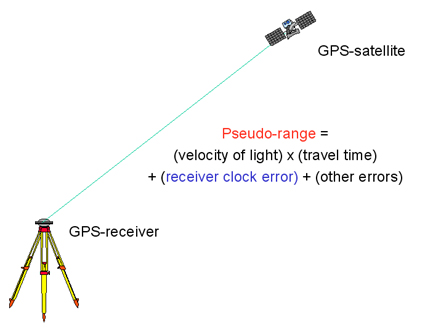

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [116]:
df_pseudorange = pd.read_excel('/content/pseudoranges1 (1).xlsx')
df_sat_pos = pd.read_excel('/content/satellite_position1 (1).xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [117]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [118]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [119]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [120]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # #...Parameters:
    # - receiver_pos: Receiver's coordinates as a numpy array [xr, yr, zr]
    # - clock_offset: Receiver clock offset (cdT)
    # - sat_pos: Array of satellite coordinates, where each row is [xs, ys, zs]
    # - pseudorange: Array of observed pseudoranges corresponding to each satellite

    # Returns:
    # - L: Sum of squared residuals (single scalar)

    #Calculating geometric distance using euclidean_norm function
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) - cdT

    #Calculate residuals between observed pseudorange and predicted pseudorange
    residuals = pseudorange - predicted_pseudorange

    #Sum of squared residuals
    L = (1/n)*np.sum(residuals ** 2)

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [121]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    # Args:
    # r_pos (np.ndarray): The 3D coordinates of the receiver (x_r, y_r, z_r).
    # cdT (float): The receiver clock offset.
    # s_pos (np.ndarray): The 3D coordinates of the satellites (x_s, y_s, z_s).
    # pseudorange (np.ndarray): The observed pseudoranges.

    # Returns:
    # np.ndarray: A 1D array containing the gradient [∂L/∂x_r, ∂L/∂y_r, ∂L/∂z_r, ∂L/∂cdT].
    # """

    # Calculate the geometric distance using the euclidean_norm function
    rho = euclidean_norm(r_pos, s_pos)
    epsilon = 0

    # Predicted pseudoranges
    predicted_pseudoranges = rho - cdT
    # Residuals
    residuals = pseudorange - predicted_pseudoranges

    # Gradients with respect to x_r, y_r, z_r
    dr_dx = (r_pos[0] - s_pos[:, 0]) / (rho + epsilon)
    dr_dy = (r_pos[1] - s_pos[:, 1]) / (rho + epsilon)
    dr_dz = (r_pos[2] - s_pos[:, 2]) / (rho + epsilon)

    # Compute the gradient components
    grad_x = (-2/n) * np.sum(residuals * dr_dx)
    grad_y = (-2/n) * np.sum(residuals * dr_dy)
    grad_z = (-2/n) * np.sum(residuals * dr_dz)
    grad_cdT = (-2/n) * np.sum(-residuals)
    # Combine the gradients into a single array
    gradient = np.array([grad_x, grad_y, grad_z, grad_cdT])
    return gradient

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [122]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [123]:
# Set values for learning rate, maximum iterations, and tolerance
learning_rate = 0.01
max_iters = 100000
tolerance = 1e-6
# Call the gradient_descent function
estimated_params = gradient_descent(pseudorange, sat_pos, learning_rate, max_iters, tolerance)
# Compute final position errors
final_position_errors = estimated_params[:3] - GroundTruth
# Get the final cost and gradient values
final_cost = cost_function(estimated_params[:3], estimated_params[3], sat_pos, pseudorange)
final_gradient = gradient(estimated_params[:3], estimated_params[3], sat_pos, pseudorange)
# Print the required results
print("Optimized Parameters (x_r, y_r, z_r, cdT):", estimated_params)
print("Final Position Errors of Receiver:", final_position_errors)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162950e+06  4.95248530e+06 -6.39730403e+00]
Final Position Errors of Receiver: [-3.05714443 -2.31699848  3.68137918]
Number of Steps Taken for Convergence: 27900
Final Cost Value: 0.5641538564668522
Final Gradient Values: [ 0.00048826  0.00272059 -0.00836153  0.00474039]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

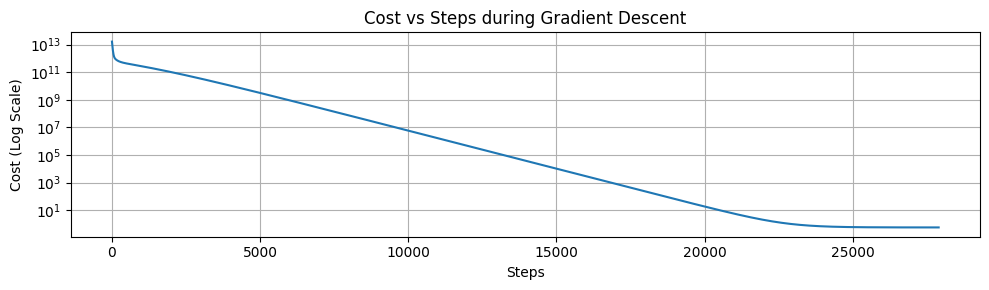

In [124]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot cost vs steps using semilogy for y-axis scaling
ax.semilogy(range(len(arr_cost)), arr_cost, label='Cost')

# Label each axis
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')

# Include figure title
ax.set_title('Cost vs Steps during Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# In this graph,it shows a sharp initial cost reduction that slows as it gets closer to convergence at about 25,000 steps, this graph illustrates how
# the cost function decreases over time as gradient descent advances. This exponential cost reduction is highlighted by the logarithmic scale,
# which also indicates that the algorithm is successfully minimizing error and gradually getting closer to an ideal value.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

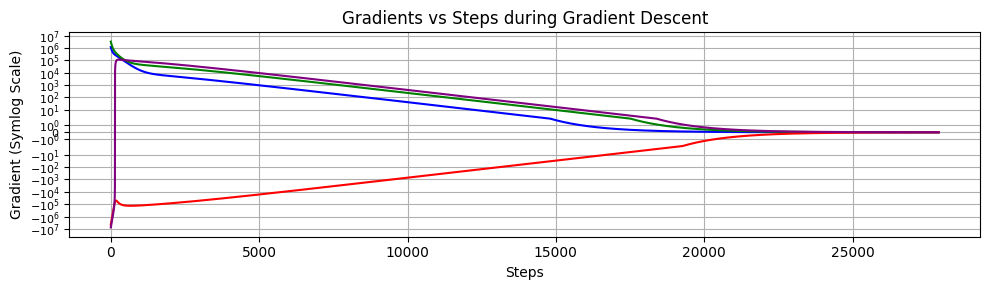

In [125]:
# Ensure arr_grad is properly converted to a numpy array
arr_grad = np.array(arr_grad)
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot each component of the gradient using symlog for y-axis scaling
ax.plot(range(len(arr_grad)), arr_grad[:, 0], label='Gradient wrt x_r', color='blue')
ax.plot(range(len(arr_grad)), arr_grad[:, 1], label='Gradient wrt y_r', color='green')
ax.plot(range(len(arr_grad)), arr_grad[:, 2], label='Gradient wrt z_r', color='red')
ax.plot(range(len(arr_grad)), arr_grad[:, 3], label='Gradient wrt cdT', color='purple')
# Use symlog to scale y-axis
ax.set_yscale('symlog')

# Set y-axis tick parameters
ax.tick_params(axis='y', labelsize=8)

# Label each axis
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient (Symlog Scale)')

# Include figure title
ax.set_title('Gradients vs Steps during Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The majority of gradients in this graph begin high and drop to almost zero, demonstrating convergence in gradient descent. The red line exhibits distinct behavior,
# progressively rising until leveling off, which could indicate a special property or characteristic. These patterns are emphasized by
# the symmetric log scale, which exhibits steady convergence with a little red gradient anomaly.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

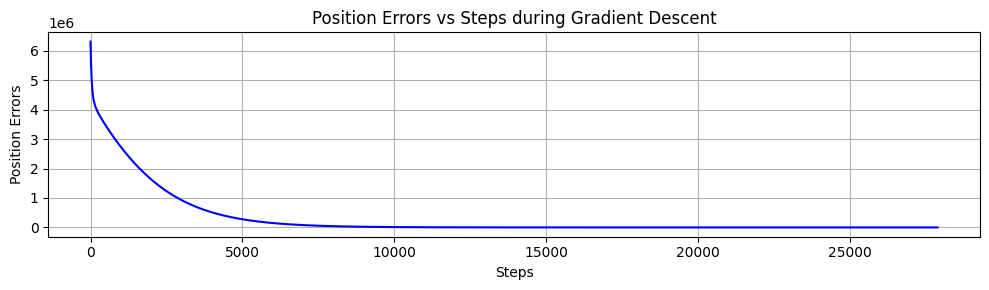

In [126]:
# Convert the error array to a numpy array for plotting
arr_err = np.array(arr_err)

# Calculate the norm of the position errors
position_errors = np.linalg.norm(arr_err, axis=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# Plot the position errors
ax.plot(range(len(position_errors)), position_errors, label='Position Errors', color='blue')

# Label each axis
ax.set_xlabel('Steps')
ax.set_ylabel('Position Errors')

# Include figure title
ax.set_title('Position Errors vs Steps during Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The decrease in location errors over steps during gradient descent is depicted in this graph. Effective convergence is indicated by the position errors, which begin extremely
# large and rapidly drop until they approach zero after around 10,000 steps. With a steady plateau at the conclusion, which indicates that the model has achieved an optimal or nearly
# optimal solution, the quick initial decline indicates effective error minimization early in training.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [132]:
arr_cost= []
arr_grad= []
arr_err=[]
# Set values for learning rate, maximum iterations, and tolerance
learning_rate = 0.01
max_iters = 100000
tolerance = 1e-6
# Call the gradient_descent function
estimated_params = gradient_descent(pseudorange, sat_pos, learning_rate, max_iters, tolerance)
# Compute final position errors
final_position_errors = estimated_params[:3] - GroundTruth
# Get the final cost and gradient values
final_cost = cost_function(estimated_params[:3], estimated_params[3], sat_pos, pseudorange)
final_gradient = gradient(estimated_params[:3], estimated_params[3], sat_pos, pseudorange)
# Print the required results
print("Optimized Parameters (x_r, y_r, z_r, cdT):", estimated_params)
print("Final Position Errors of Receiver:", final_position_errors)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162950e+06  4.95248530e+06 -6.39730403e+00]
Final Position Errors of Receiver: [-3.05714443 -2.31699848  3.68137918]
Number of Steps Taken for Convergence: 27900
Final Cost Value: 0.5641538564668522
Final Gradient Values: [ 0.00048826  0.00272059 -0.00836153  0.00474039]


In [136]:
# Set values for learning rate, maximum iterations, and tolerance
learning_rate = 0.001
max_iters = 300000
tolerance = 1e-6
# Call the gradient_descent function
estimated_params = gradient_descent(pseudorange, sat_pos, learning_rate, max_iters, tolerance)
# Compute final position errors
final_position_errors = estimated_params[:3] - GroundTruth
# Get the final cost and gradient values
final_cost = cost_function(estimated_params[:3], estimated_params[3], sat_pos, pseudorange)
final_gradient = gradient(estimated_params[:3], estimated_params[3], sat_pos, pseudorange)
# Print the required results
print("Learning Rate 0.001")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", estimated_params)
print("Final Position Errors of Receiver:", final_position_errors)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged !
Learning Rate 0.001
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349242e+06 -3.65162941e+06  4.95248502e+06 -6.23556836e+00]
Final Position Errors of Receiver: [-3.04048553 -2.2241755   3.39609526]
Number of Steps Taken for Convergence: 260921
Final Cost Value: 0.5712606883461405
Final Gradient Values: [ 0.00154528  0.00861028 -0.02646298  0.01500263]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

In [137]:
#Answer 1:After altering the learning rate from 0.01 to 0.001, there was little discernible change because both
#provided identical outcomes and led to convergence at comparable steps. This suggests that, independent of learning rate,
#the algorithm is reliable and efficient in locating the best answer. This shows that even with varying step sizes, your implementation is
#reliable and effectively traverses the optimization landscape.


In [138]:
#Ans 2: By solving linear equations directly, LSE offers a precise solution in a single step, although it can be susceptible to numerical problems.
#Gradient Descent is robust and flexible enough to handle non-linear issues since it iteratively minimizes the cost function.
#According to the results,both approaches converged to the best answer; however, Gradient Descent continuously shown
#strong convergence and adaptability to varying learning rates, successfully lowering expenses and errors.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [140]:
!pip install ucimlrepo

In [142]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets
#convert to dataframe
x = pd.DataFrame(X, columns = phishing_websites.metadata.feature_names)
y = pd.DataFrame(y, columns = phishing_websites.metadata.target_names)
# TO DO: display sizes of X and y (1 mark)
print("Size of X:", x.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [143]:
!pip install seaborn

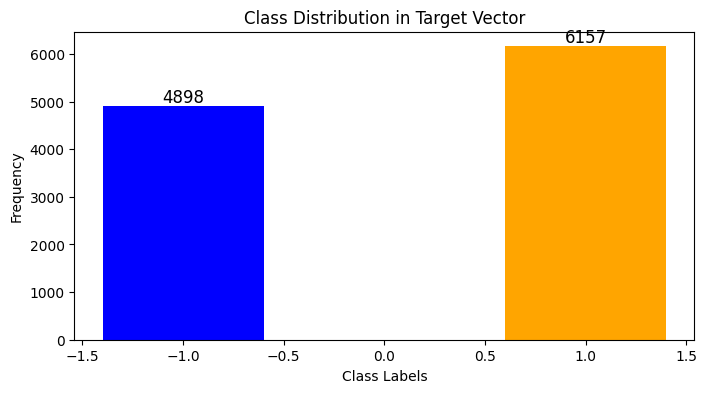

In [144]:
# TO DO: Check the class distribution of y (2 mark)
# Count the unique values and their frequencies in y
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot the histogram for each class label
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])

# Add exact values above each bar
for i, count in zip(class_counts.keys(), class_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

# Set plot labels and title
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution in Target Vector")

# Display the plot
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [183]:
from sklearn.model_selection import train_test_split
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print(f"Size of X_small: {X_small.shape}")
print(f"Size of y_small: {y_small.shape}")

Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [185]:
#Instantiate model LogisticRegression(max_iter=2000)
model_full = LogisticRegression(max_iter=2000)
y = y.ravel()  # Converts the target to a 1D array (if it's a 2D column vector
#Train (fit) the model on the full dataset
model_full.fit(X, y.ravel())

LogisticRegression(max_iter=2000)

In [186]:
#Train the model on the full dataset

y_pred_full = model_full.predict(X)
accuracy_full = accuracy_score(y, y_pred_full)
print(f"Accuracy with full dataset: {accuracy_full:.2f}")

Accuracy with full dataset: 0.93


In [187]:
# Ensure y_small is a 1D array by converting it to a numpy array and then flattening it
y_small = np.array(y_small).ravel()
# Instantiate and train (fit) the model on the smaller dataset
model_small = LogisticRegression(max_iter=2000)
model_small.fit(X_small, y_small)

y_pred_small = model_small.predict(X_small)
accuracy_small = accuracy_score(y_small, y_pred_small)
print(f"Accuracy with smaller dataset: {accuracy_small:.2f}")

Accuracy with smaller dataset: 0.95


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [188]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Function to train and evaluate the model
def train_and_evaluate(X, y, random_state=0):
    # Split the data into training and testing sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    loss = log_loss(y_test, y_test_proba)

    return {
        "Data Size": X.shape[0],
        "Training Samples": X_train.shape[0],
        "Testing Samples": X_test.shape[0],
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": loss  # Ensure that the key is clean
    }

# Assuming X and y are already defined (e.g., from pandas DataFrame)

# 1. Full Dataset (X and y)
results_full = train_and_evaluate(X, y)

# 2. First Two Columns of X and y
X_two_columns = X.iloc[:, :2]  # Already handles pandas input
results_two_columns = train_and_evaluate(X_two_columns, y)

# 3. Smaller Dataset (X_small and y_small)
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
results_small = train_and_evaluate(X_small, y_small)


# Print the results for Step 4
print("Results for Full Dataset:")
print(f"Data Size: {results_full['Data Size']}")
print(f"Number of Training Samples: {results_full['Training Samples']}")
print(f"Number of Testing Samples: {results_full['Testing Samples']}")
print(f"Training Accuracy: {results_full['Training Accuracy']:.2f}")
print(f"Testing Accuracy: {results_full['Testing Accuracy']:.2f}")
print(f"Log Loss: {results_full['Log Loss']:.2f}\n")

print("Results for First Two Columns of X:")
print(f"Data Size: {results_two_columns['Data Size']}")
print(f"Number of Training Samples: {results_two_columns['Training Samples']}")
print(f"Number of Testing Samples: {results_two_columns['Testing Samples']}")
print(f"Training Accuracy: {results_two_columns['Training Accuracy']:.2f}")
print(f"Testing Accuracy: {results_two_columns['Testing Accuracy']:.2f}")
print(f"Log Loss: {results_two_columns['Log Loss']:.2f}\n")

print("Results for Smaller Dataset:")
print(f"Data Size: {results_small['Data Size']}")
print(f"Number of Training Samples: {results_small['Training Samples']}")
print(f"Number of Testing Samples: {results_small['Testing Samples']}")
print(f"Training Accuracy: {results_small['Training Accuracy']:.2f}")
print(f"Testing Accuracy: {results_small['Testing Accuracy']:.2f}")
print(f"Log Loss: {results_small['Log Loss']:.2f}\n")


Results for Full Dataset:
Data Size: 11055
Number of Training Samples: 7738
Number of Testing Samples: 3317
Training Accuracy: 0.93
Testing Accuracy: 0.92
Log Loss: 0.19

Results for First Two Columns of X:
Data Size: 11055
Number of Training Samples: 7738
Number of Testing Samples: 3317
Training Accuracy: 0.56
Testing Accuracy: 0.56
Log Loss: 0.68

Results for Smaller Dataset:
Data Size: 331
Number of Training Samples: 231
Number of Testing Samples: 100
Training Accuracy: 0.94
Testing Accuracy: 0.91
Log Loss: 0.20



### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---